In [ ]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from environment import TrackingEnv
import random
from collections import deque

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

NUM_NEURONS = 256
LR_ACTOR = 0.001
LR_CRITIC = 0.0001
GAMMA = 0.99
TAU = 0.005
EARLY_STOPPING_EPISODES = 30

class PolicyNet(nn.Module):
    
    def __init__(self, state_dim, action_dim, max_action=0.1):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(state_dim, NUM_NEURONS)
        self.fc2 = nn.Linear(NUM_NEURONS, NUM_NEURONS)
        self.fc3 = nn.Linear(NUM_NEURONS, action_dim)
        nn.init.uniform_(self.fc3.weight, -3e-3, 3e-3)
        nn.init.uniform_(self.fc3.bias, -3e-3, 3e-3)

        #self.max_action = max_action  # usato per riscalare l'output

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        #action = self.max_action * torch.tanh(self.fc3(x))
        action = torch.tanh(self.fc3(x))
        return action

class QNet(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(QNet, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)  # Concatenazione lungo la dimensione delle features
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        q_value = self.fc3(x)
        return q_value

class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)
        self.position = 0

    def push(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

class OUNoise:
    def __init__(self, action_dim, mu=0.0, theta=0.15, sigma=0.1):
        self.action_dim = action_dim
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.state = np.ones(self.action_dim) * self.mu
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu

    def sample(self):
        dx = self.theta * (self.mu - self.state) + self.sigma * np.random.randn(self.action_dim)
        self.state += dx
        return self.state


class DDPGAgent(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DDPGAgent, self).__init__()
        self.actor = PolicyNet(num_inputs, num_actions)
        self.actor_target = PolicyNet(num_inputs, num_actions)
        self.critic = QNet(num_inputs, num_actions)
        self.critic_target = QNet(num_inputs, num_actions)
        self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=LR_ACTOR)
        self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=LR_CRITIC)
        self.buffer = ReplayBuffer(50000)
        self.uo_noise = OUNoise(num_actions)
        self.batch_size = 64
        self.noise_std = 0.3
        self.min_noise_std = 0.01
        self.noise_decay = 0.995

    
    def reward_function(self, state, action, next_state, step, tolerance, rimbalzato, attached_counter):
        #reward = - torch.norm(next_state[:2] - state[2:4]) -1
        pos = state[:2]
        target = state[2:4]              # target(t)
        next_pos = next_state[:2]        # agent(t+1)

        to_target = F.normalize(target - pos, dim=0)
        action_dir = F.normalize(action, dim=0)
        direction_reward = torch.dot(action_dir, to_target)
        direction_penalty = 1.0 - direction_reward

        reward = - direction_penalty

        if torch.norm(next_state[:2] - state[2:4]) < tolerance:
            reward += 50
        
        if rimbalzato:
            reward -= 5

        return reward - 1

    def update(self, gamma=GAMMA, tau=TAU, device='cpu'):
        if len(self.buffer) < self.batch_size:
            return  # aspetta di avere abbastanza dati

        # Campiona un batch
        transitions = random.sample(self.buffer.buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*transitions)

        # Converti in tensori
        states      = torch.FloatTensor(np.array(states)).to(device)
        actions     = torch.FloatTensor(np.array(actions)).to(device)
        rewards     = torch.FloatTensor(np.array(rewards)).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(np.array(next_states)).to(device)
        dones       = torch.FloatTensor(np.array(dones)).unsqueeze(1).to(device)

        # ------------------ Critic update ------------------
        with torch.no_grad():
            next_actions = self.actor_target(next_states)
            target_Q = self.critic_target(next_states, next_actions)
            y = rewards + gamma * target_Q * (1 - dones)

        current_Q = self.critic(states, actions)
        critic_loss = F.mse_loss(current_Q, y)

        self.optimizer_critic.zero_grad()
        critic_loss.backward()
        self.optimizer_critic.step()

        # ------------------ Actor update -------------------
        actor_loss = -self.critic(states, self.actor(states)).mean()

        self.optimizer_actor.zero_grad()
        actor_loss.backward()
        self.optimizer_actor.step()

        # ------------- Soft update dei target --------------
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

def train_ddpg(env=None, num_episodes=4000):
    if env is None:
        env = TrackingEnv()
    num_inputs = env.observation_space.shape[0]
    num_actions = env.action_space.shape[0]
    agent = DDPGAgent(num_inputs, num_actions)
    reward_history = []
    success_history = []
    counter = 0
    tolerance = 0.02

    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0
        state = torch.tensor(state, dtype=torch.float32)
        trajectory = []
        target_trajectory = []
        step = 0
        attached_counter = 0
        agent.uo_noise.reset()  # Reset del rumore OU a inizio episodio
        
        while not done:
            step += 1
            trajectory.append(state[:2].detach().cpu().numpy())
            target_trajectory.append(state[2:4].detach().cpu().numpy())

            # Azione deterministica + rumore esplorativo
            action = agent.actor(state).detach()
            # if step == 50:
            #     print(action)
            #noise = agent.uo_noise.sample()
            #noisy_action = np.clip(action + noise, -0.1, 0.1)
            noise = np.random.normal(0, agent.noise_std, size=action.shape)
            agent.noise_std = max(agent.min_noise_std, agent.noise_std * agent.noise_decay)
            noisy_action = action + noise
            action_tensor = torch.tensor(noisy_action, dtype=torch.float32)

            next_state, _, done, truncated, _, rimbalzato = env.step(noisy_action)
            next_state = torch.tensor(next_state, dtype=torch.float32)

            if torch.norm(next_state[:2] - next_state[2:4]) < tolerance or truncated:
                done = True

            reward = agent.reward_function(state, action_tensor, next_state, step, tolerance, rimbalzato, attached_counter)
            transition = ((state, action_tensor, reward, next_state, float(done)))
            #print(f"Transtion: {transition}")
            agent.buffer.push(transition)
            #print(f"Buffer size: {len(agent.buffer)}")

            # Aggiorna le reti
            agent.update()

            state = next_state
            total_reward += reward.item()

        # Salvataggio e visualizzazione
        if torch.norm(next_state[:2] - next_state[2:4]) < tolerance:
            counter += 1
            success_history.append(1)
            print(f"SUCCESSO Episode: {episode}, Step: {step}, Counter: {counter}, Total reward: {total_reward}")
            if counter % 10 == 0:
                trajectory = np.array(trajectory)
                target_trajectory = np.array(target_trajectory)
                plt.figure(figsize=(5, 5))
                plt.plot(trajectory[:, 0], trajectory[:, 1], label="Agente", color='blue')
                plt.plot(target_trajectory[:, 0], target_trajectory[:, 1], label="Target", color='red')
                plt.scatter(*trajectory[0], color='green', label='Start agente', s=100)
                plt.scatter(*target_trajectory[0], color='yellow', label='Start target', s=100)
                plt.scatter(*target_trajectory[-1], color='red', label='End agente', s=100)
                plt.scatter(target_trajectory[-5:, 0], target_trajectory[-5:, 1], color='orange', label='Ultimi target', s=10)
                plt.scatter(trajectory[-5:, 0], trajectory[-5:, 1], color='purple', label='Ultimi agente', s=10)
                plt.title(f"Traiettoria episodio {episode}, SUCCESSO")
                plt.xlabel("X")
                plt.ylabel("Y")
                plt.legend()
                plt.grid()
                plt.axis('equal')
                plt.show()
        else:
            success_history.append(0)

        reward_history.append(total_reward)

        if episode % 10 == 0:
            print(f"Episode: {episode}, Step: {step}, Counter: {counter}, Total reward: {total_reward}, final state: {state.cpu().numpy()}")
            
        # if episode % 10 == 0:
        #     trajectory = np.array(trajectory)
        #     target_trajectory = np.array(target_trajectory)
        #     plt.figure(figsize=(5, 5))
        #     plt.plot(trajectory[:, 0], trajectory[:, 1], label="Agente", color='blue')
        #     plt.plot(target_trajectory[:, 0], target_trajectory[:, 1], label="Target", color='red')
        #     plt.scatter(*trajectory[0], color='green', label='Start agente', s=100)
        #     plt.scatter(*target_trajectory[0], color='yellow', label='Start target', s=100)
        #     plt.scatter(*target_trajectory[-1], color='red', label='End agente', s=100)
        #     plt.scatter(target_trajectory[-5:, 0], target_trajectory[-5:, 1], color='orange', label='Ultimi target', s=10)
        #     plt.scatter(trajectory[-5:, 0], trajectory[-5:, 1], color='purple', label='Ultimi agente', s=10)
        #     plt.title(f"Traiettoria episodio {episode}")
        #     plt.xlabel("X")
        #     plt.ylabel("Y")
        #     plt.legend()
        #     plt.grid()
        #     plt.axis('equal')
        #     plt.show()
        
        
        #if len(reward_history) > EARLY_STOPPING_EPISODES and np.mean(reward_history[-EARLY_STOPPING_EPISODES:]) > -30:
        #    print(f"Early stopping at episode {episode}")
        #    break

    env.close()

    plt.plot(reward_history)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Training Progress')
    plt.show()

    return agent

if __name__ == "__main__":
    trained_agent = train_ddpg()

In [ ]:
# Per salvare solo i pesi
torch.save(trained_agent.actor.state_dict(), "ddpg_policy.pt")
torch.save(trained_agent.critic.state_dict(), "ddpg_critic.pt")

In [ ]:
def test_agent_with_random_targets(agent, env=None, num_episodes=100, target_sampler=None, tolerance=0.02):
    if env is None:
        env = TrackingEnv()

    agent.eval()

    final_distances = []
    success_counter = 0

    for ep in range(num_episodes):
        # # Genera un target casuale (es. all’interno di uno spazio 2D limitato)
        # if target_sampler:
        #     target = target_sampler()
        #     target = torch.tensor(target, dtype=torch.float32)
        # else:
        #     target = np.random.uniform(low=-0.5, high=0.5, size=(2,))  # Default sampler
        #     target = torch.tensor(target, dtype=torch.float32)

        state, _ = env.reset()#target=target)
        state = torch.tensor(state, dtype=torch.float32)

        done = False
        step = 0
        trajectory = []

        while not done:
            trajectory.append(state.detach().numpy())
            action, _ = agent.get_action(state)
            next_state, _, done, truncated, _, rimbalzato = env.step(action)
            next_state = torch.tensor(next_state, dtype=torch.float32)
            if torch.norm(next_state[:2] - next_state[2:4]) < tolerance or truncated:
                done = True
            state = next_state
            step += 1

        trajectory = np.array(trajectory)
        final_dist = np.linalg.norm(state[:2] - state[2:4])
        final_distances.append(final_dist)
        print(f"[Episode {ep}] Steps: {step}, Final distance: {final_dist:.4f}")

        success = False

        if final_dist < tolerance:
            success = True
            success_counter += 1


        #if success and ep % 10 == 0:
        plt.figure(figsize=(5, 5))
        plt.plot(trajectory[:, 0], trajectory[:, 1], marker='o', label="Traiettoria")
        plt.scatter(*state[2:4], color='red', label='Target', s=100)
        plt.scatter(trajectory[0, 0], trajectory[0, 1], color='green', label='Start', s=100)
        plt.title(f"Test con target casuale – episodio {ep}, successo: {success}")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.legend()
        plt.grid()
        plt.axis('equal')
        plt.show()

    env.close()

    print(f"Media delle distanze finali: {np.mean(final_distances):.4f}, numero di successi: {success_counter}")


test_agent_with_random_targets(trained_agent)

[Episode 0] Steps: 400, Final distance: 0.0669, Success: False


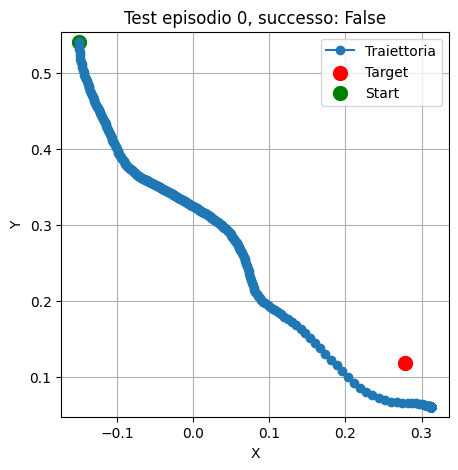

[Episode 1] Steps: 400, Final distance: 0.0519, Success: False


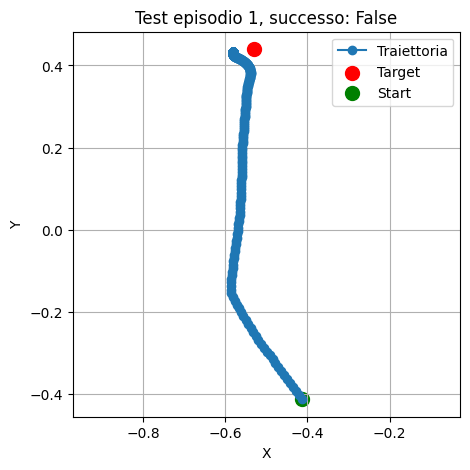

[Episode 2] Steps: 309, Final distance: 0.0166, Success: True


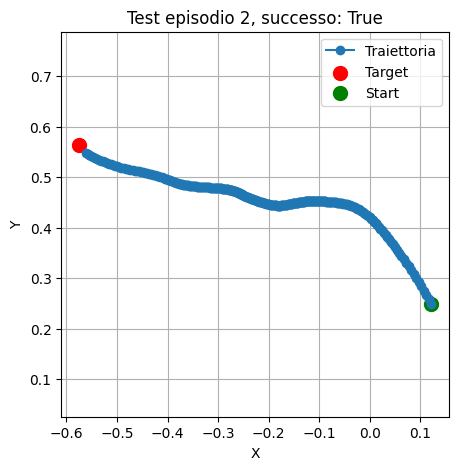

[Episode 3] Steps: 151, Final distance: 0.0198, Success: True


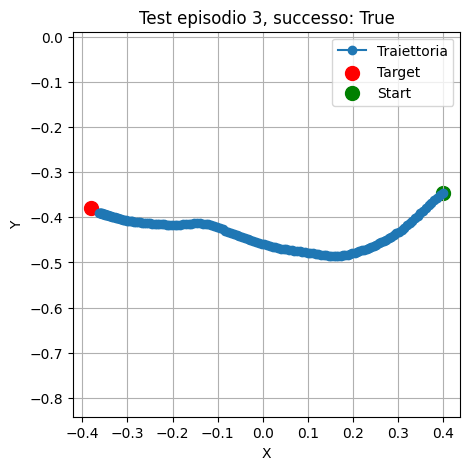

[Episode 4] Steps: 400, Final distance: 0.0221, Success: False


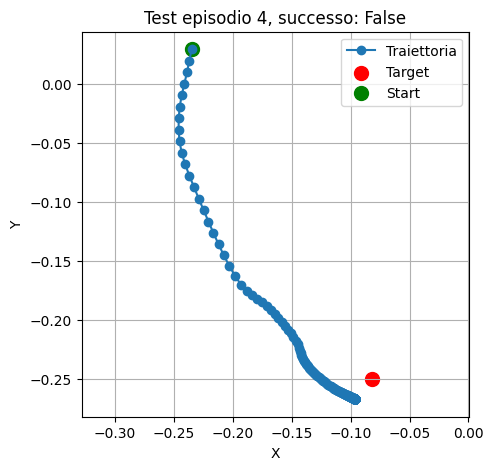

[Episode 5] Steps: 83, Final distance: 0.0183, Success: True


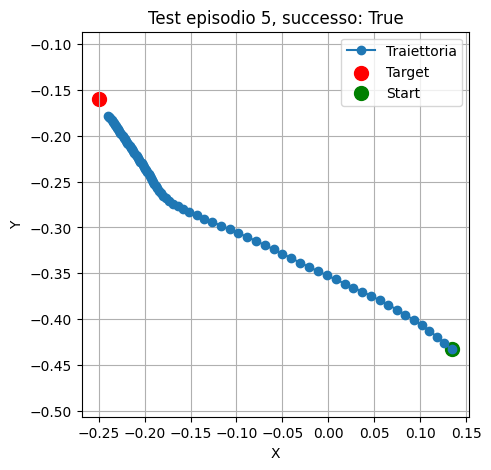

[Episode 6] Steps: 400, Final distance: 0.0657, Success: False


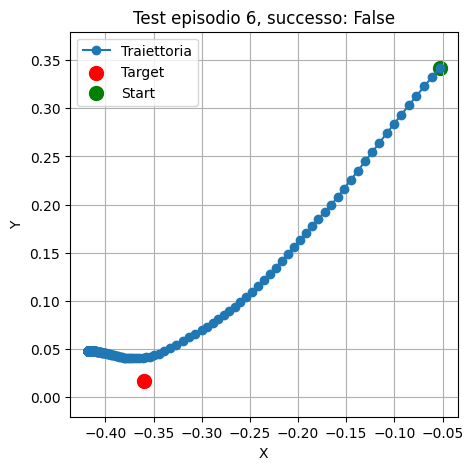

[Episode 7] Steps: 20, Final distance: 0.0167, Success: True


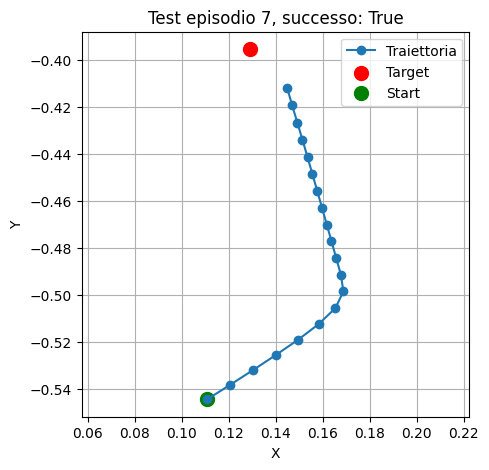

[Episode 8] Steps: 400, Final distance: 0.1693, Success: False


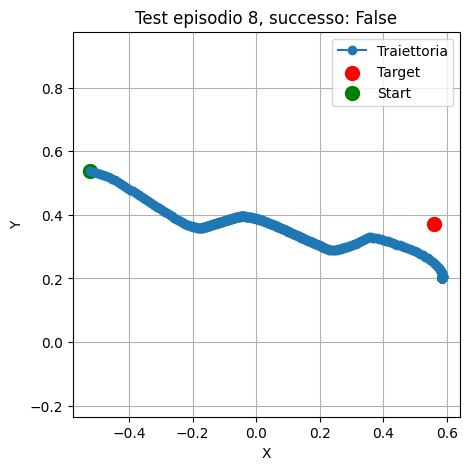

[Episode 9] Steps: 400, Final distance: 0.0271, Success: False


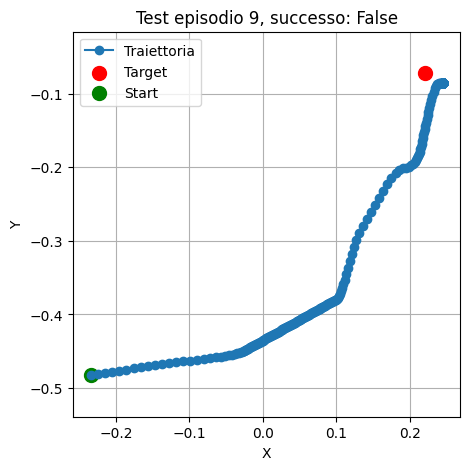

[Episode 10] Steps: 400, Final distance: 0.0931, Success: False


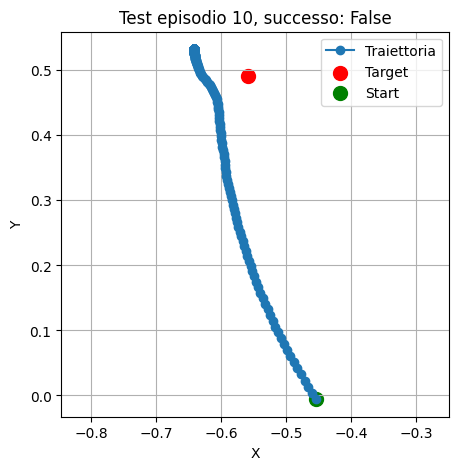

[Episode 11] Steps: 400, Final distance: 0.0997, Success: False


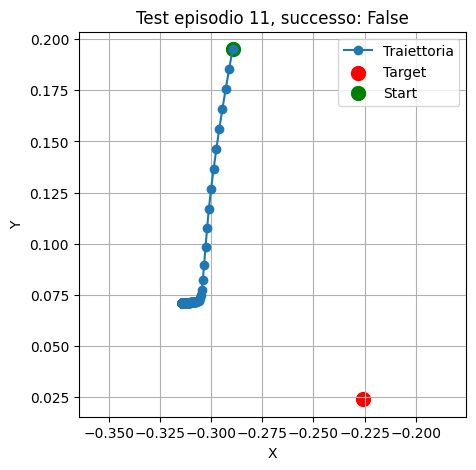

[Episode 12] Steps: 400, Final distance: 0.1503, Success: False


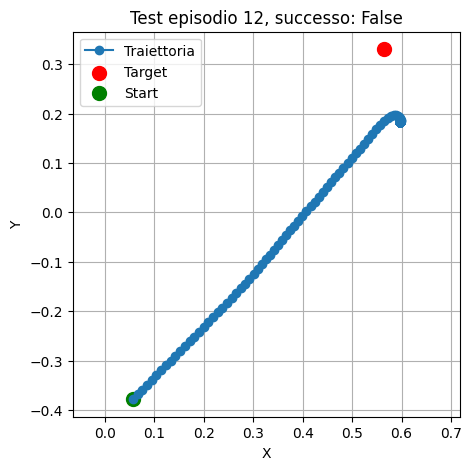

[Episode 13] Steps: 48, Final distance: 0.0168, Success: True


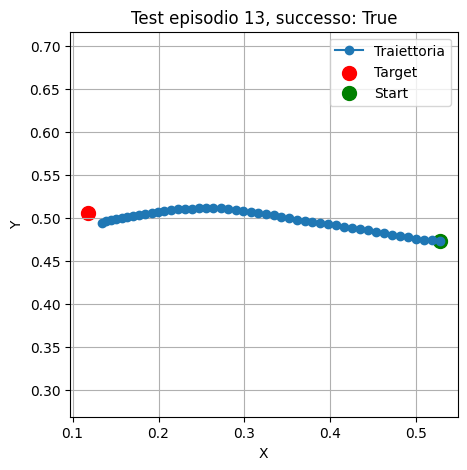

[Episode 14] Steps: 400, Final distance: 0.0553, Success: False


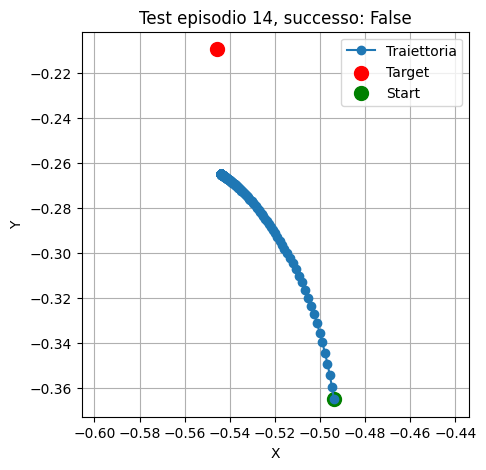

[Episode 15] Steps: 400, Final distance: 0.0377, Success: False


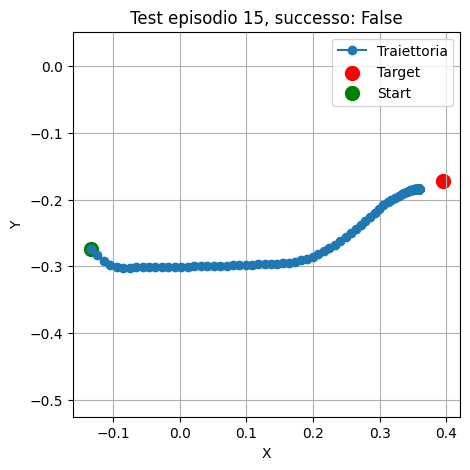

[Episode 16] Steps: 107, Final distance: 0.0182, Success: True


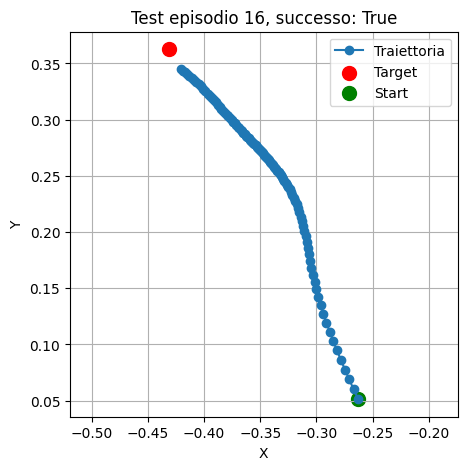

[Episode 17] Steps: 400, Final distance: 0.5677, Success: False


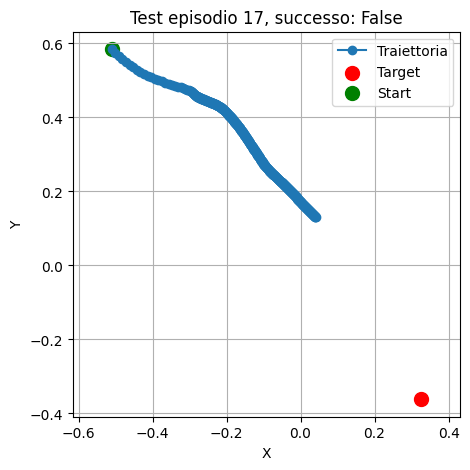

[Episode 18] Steps: 400, Final distance: 0.0311, Success: False


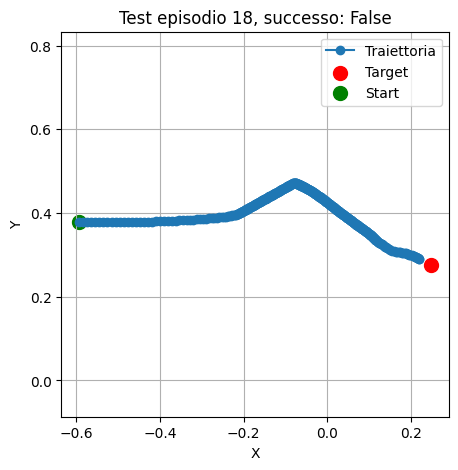

[Episode 19] Steps: 400, Final distance: 0.2407, Success: False


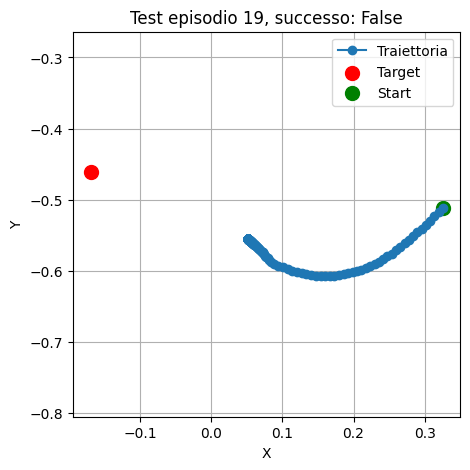

[Episode 20] Steps: 400, Final distance: 0.2747, Success: False


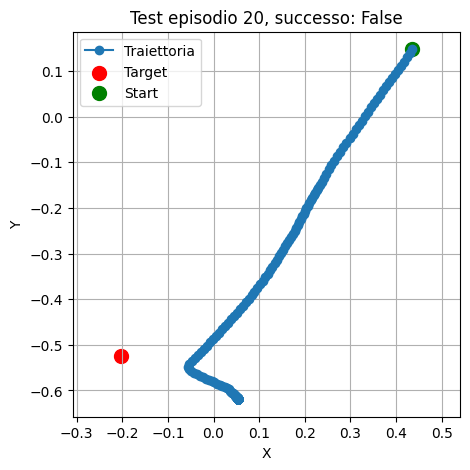

[Episode 21] Steps: 400, Final distance: 0.0443, Success: False


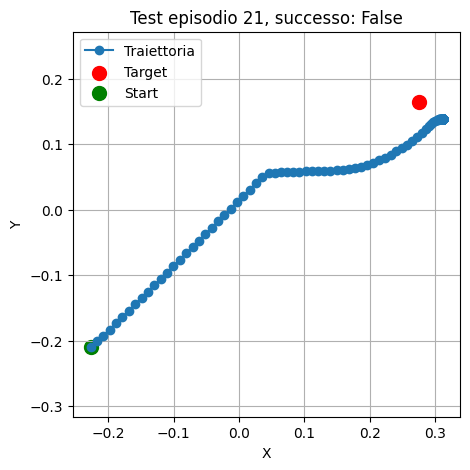

[Episode 22] Steps: 208, Final distance: 0.0198, Success: True


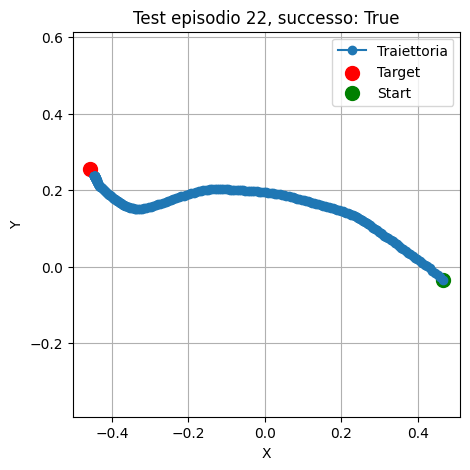

[Episode 23] Steps: 8, Final distance: 0.0164, Success: True


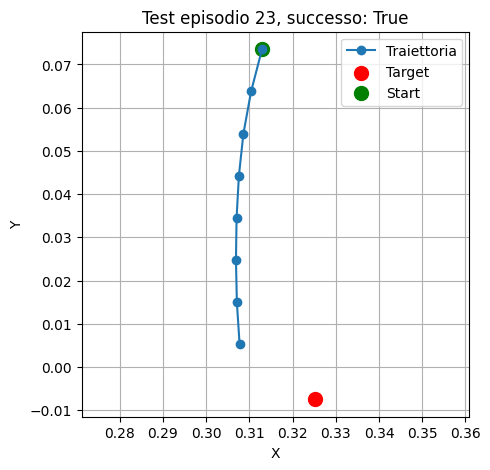

[Episode 24] Steps: 400, Final distance: 0.5174, Success: False


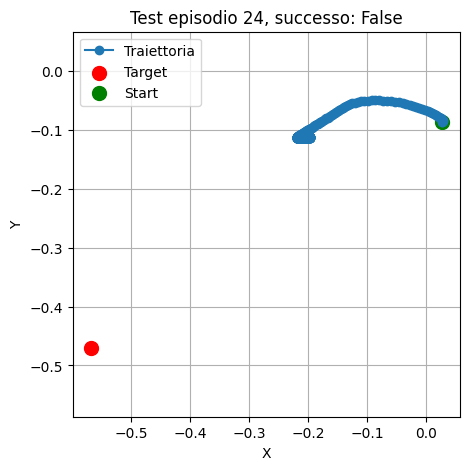

[Episode 25] Steps: 400, Final distance: 0.1003, Success: False


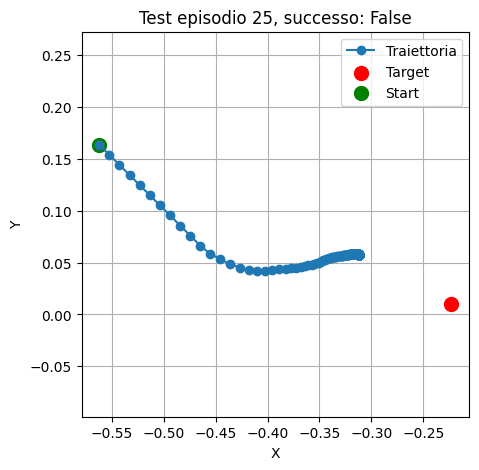

[Episode 26] Steps: 400, Final distance: 1.2616, Success: False


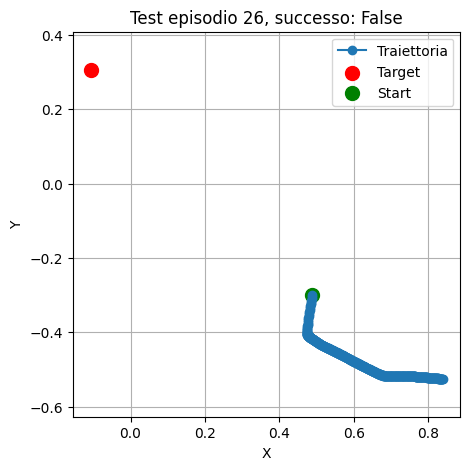

[Episode 27] Steps: 400, Final distance: 0.1989, Success: False


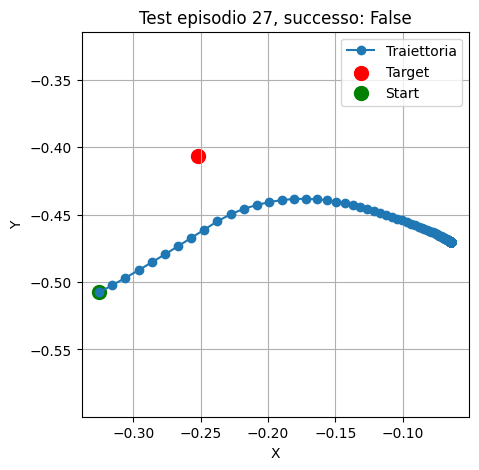

[Episode 28] Steps: 46, Final distance: 0.0180, Success: True


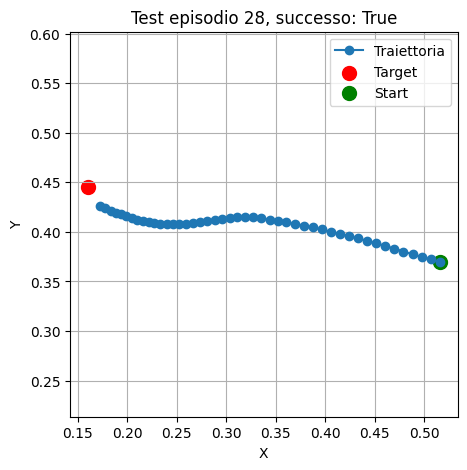

[Episode 29] Steps: 400, Final distance: 0.1254, Success: False


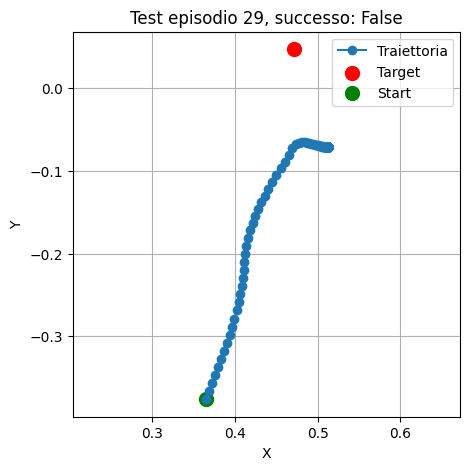

[Episode 30] Steps: 400, Final distance: 0.2530, Success: False


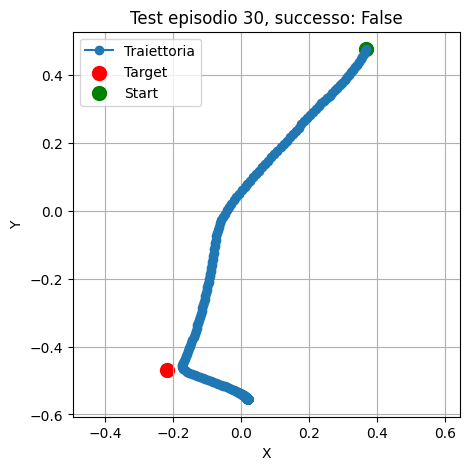

[Episode 31] Steps: 400, Final distance: 0.1203, Success: False


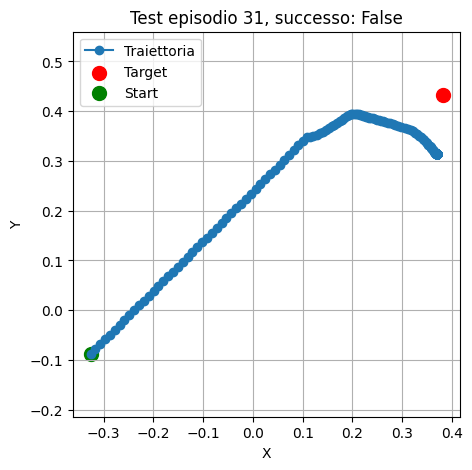

[Episode 32] Steps: 92, Final distance: 0.0186, Success: True


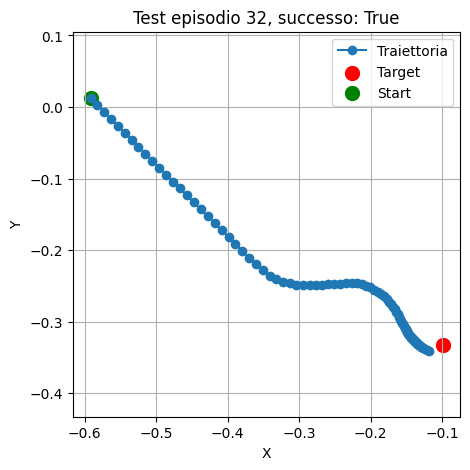

[Episode 33] Steps: 400, Final distance: 0.0450, Success: False


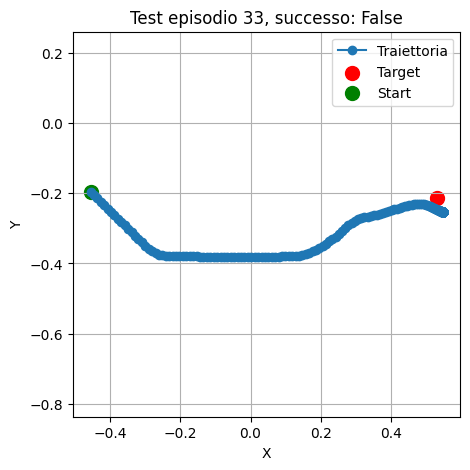

[Episode 34] Steps: 50, Final distance: 0.0199, Success: True


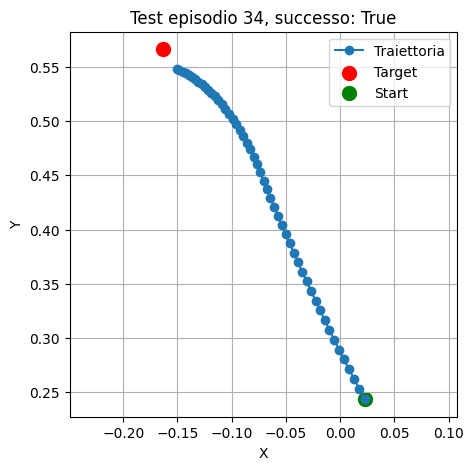

[Episode 35] Steps: 236, Final distance: 0.0198, Success: True


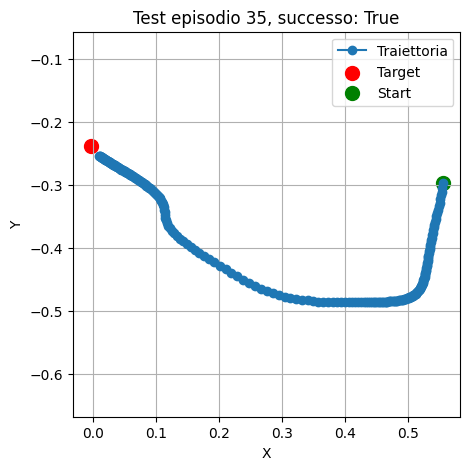

[Episode 36] Steps: 199, Final distance: 0.0197, Success: True


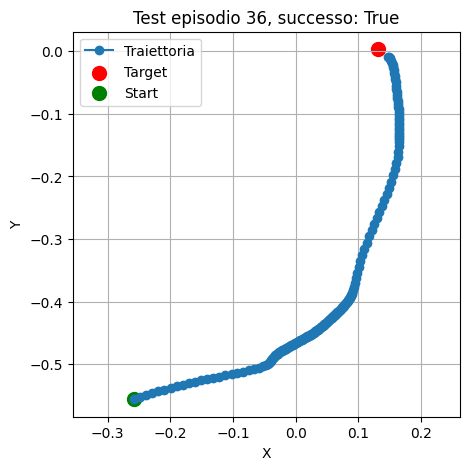

[Episode 37] Steps: 400, Final distance: 0.0491, Success: False


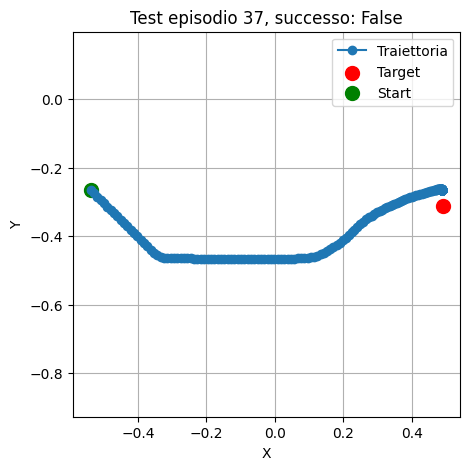

[Episode 38] Steps: 110, Final distance: 0.0157, Success: True


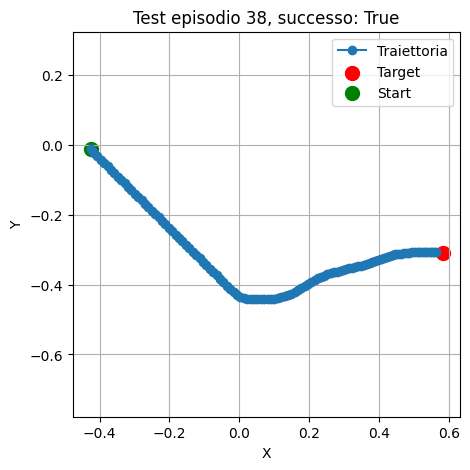

[Episode 39] Steps: 162, Final distance: 0.0186, Success: True


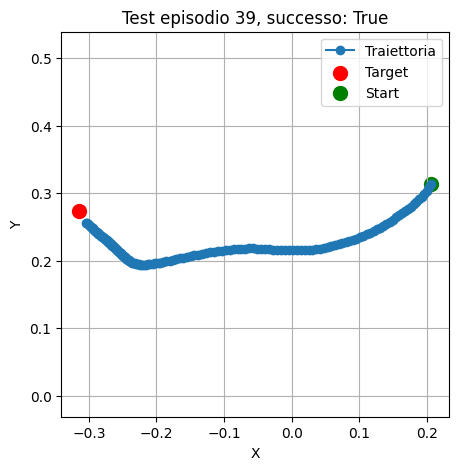

[Episode 40] Steps: 400, Final distance: 0.0276, Success: False


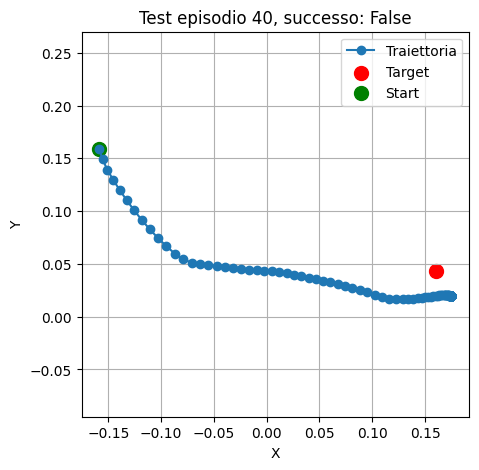

[Episode 41] Steps: 400, Final distance: 0.7843, Success: False


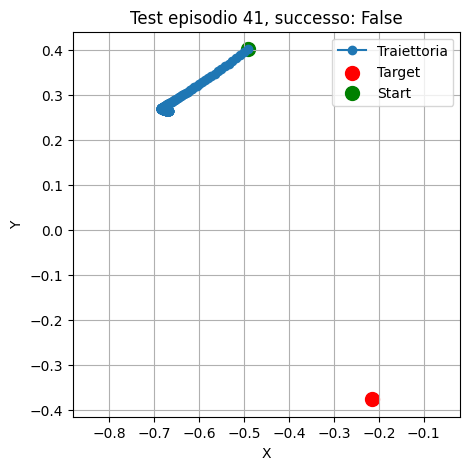

[Episode 42] Steps: 400, Final distance: 0.1122, Success: False


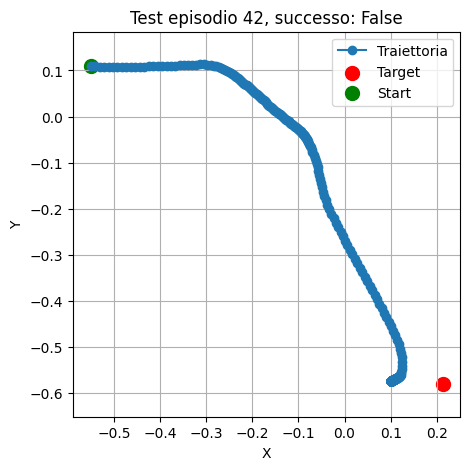

[Episode 43] Steps: 400, Final distance: 0.0590, Success: False


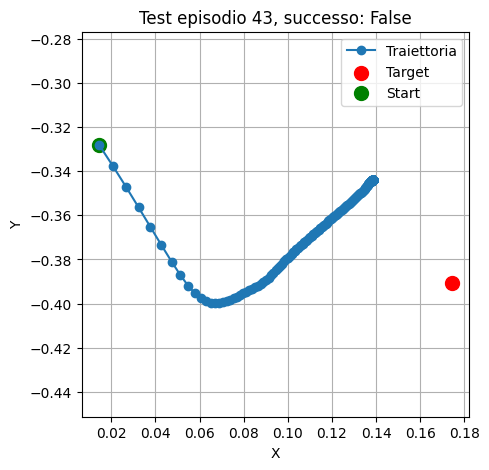

[Episode 44] Steps: 400, Final distance: 0.1865, Success: False


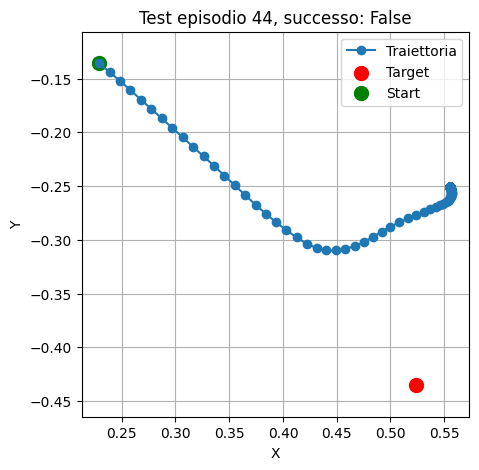

[Episode 45] Steps: 400, Final distance: 0.1537, Success: False


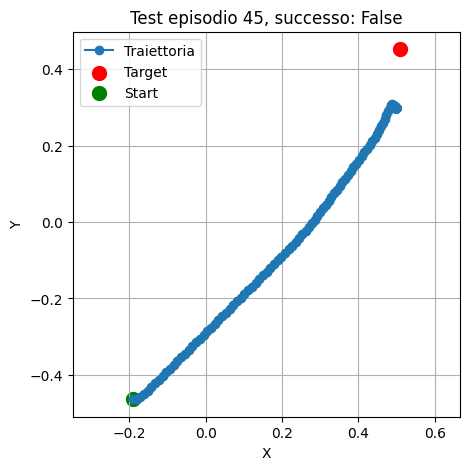

[Episode 46] Steps: 400, Final distance: 0.1213, Success: False


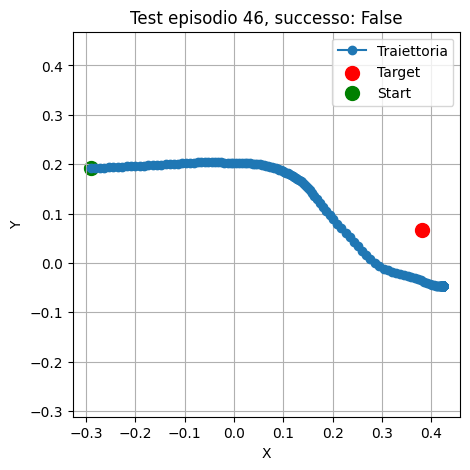

[Episode 47] Steps: 244, Final distance: 0.0200, Success: True


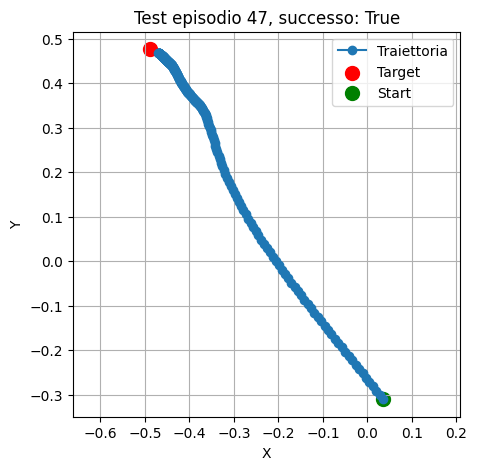

[Episode 48] Steps: 156, Final distance: 0.0195, Success: True


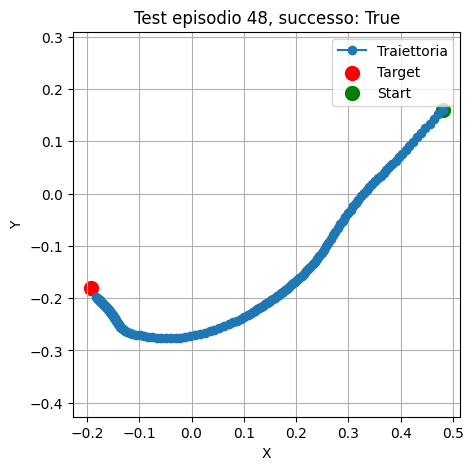

[Episode 49] Steps: 400, Final distance: 0.1429, Success: False


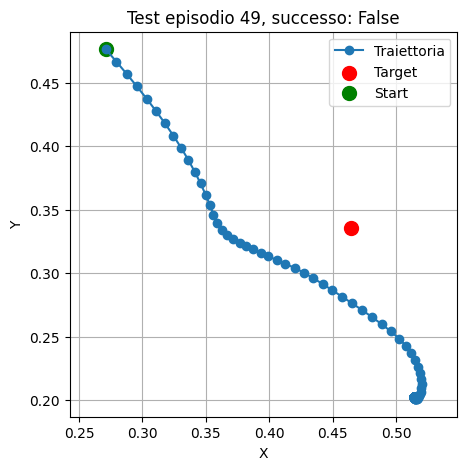

[Episode 50] Steps: 400, Final distance: 0.0367, Success: False


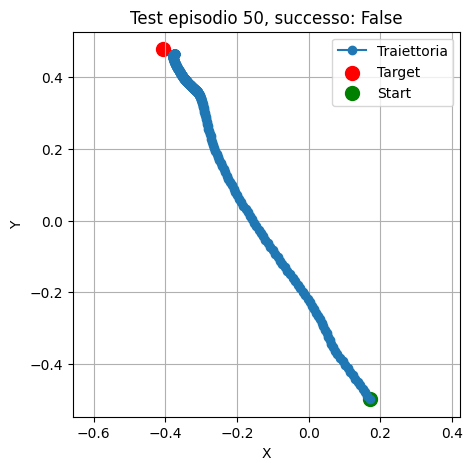

[Episode 51] Steps: 400, Final distance: 0.0391, Success: False


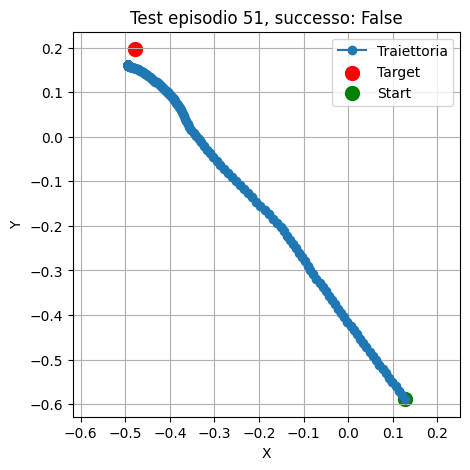

[Episode 52] Steps: 117, Final distance: 0.0197, Success: True


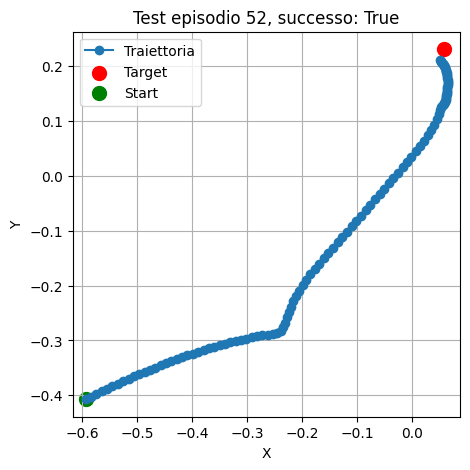

[Episode 53] Steps: 400, Final distance: 0.0611, Success: False


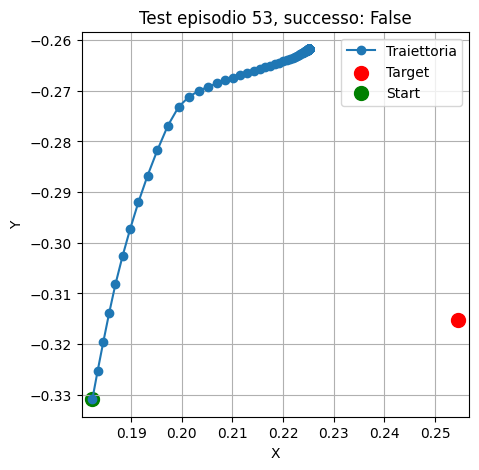

[Episode 54] Steps: 400, Final distance: 0.0667, Success: False


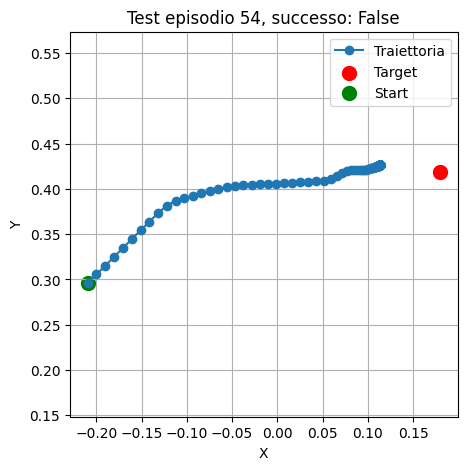

[Episode 55] Steps: 400, Final distance: 0.0578, Success: False


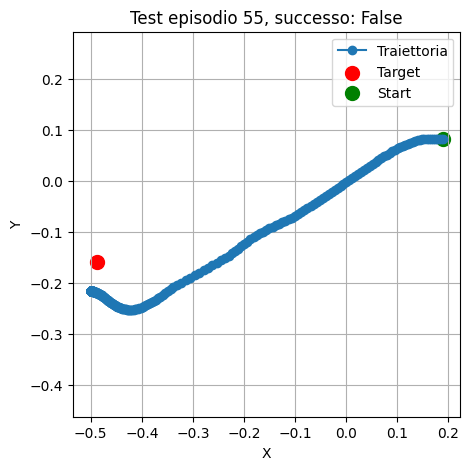

[Episode 56] Steps: 400, Final distance: 0.0813, Success: False


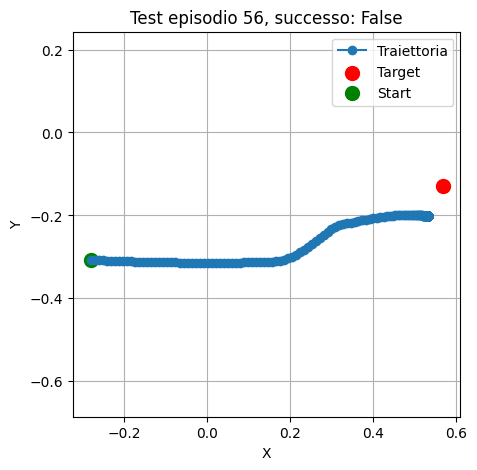

[Episode 57] Steps: 400, Final distance: 0.0928, Success: False


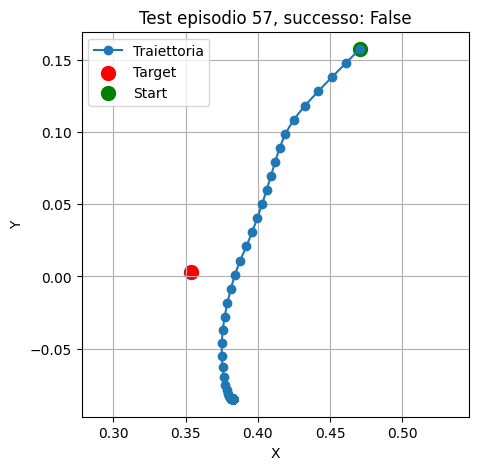

[Episode 58] Steps: 116, Final distance: 0.0194, Success: True


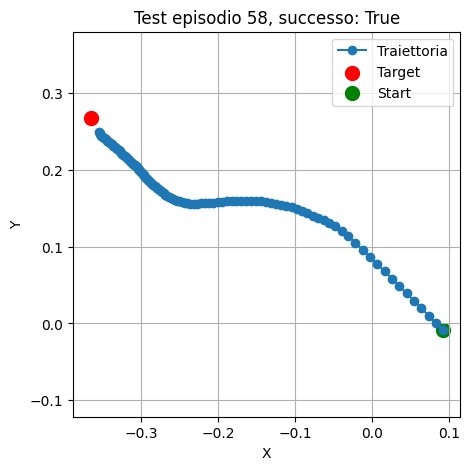

[Episode 59] Steps: 400, Final distance: 0.0588, Success: False


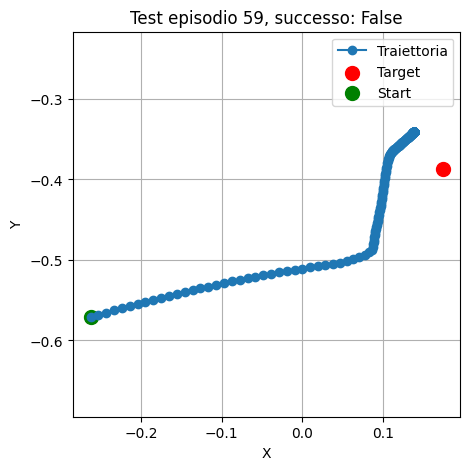

[Episode 60] Steps: 85, Final distance: 0.0200, Success: True


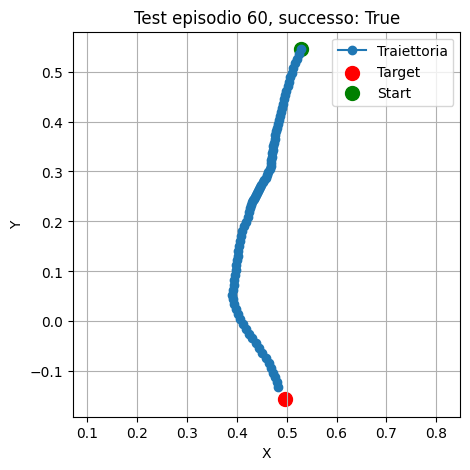

[Episode 61] Steps: 400, Final distance: 0.0587, Success: False


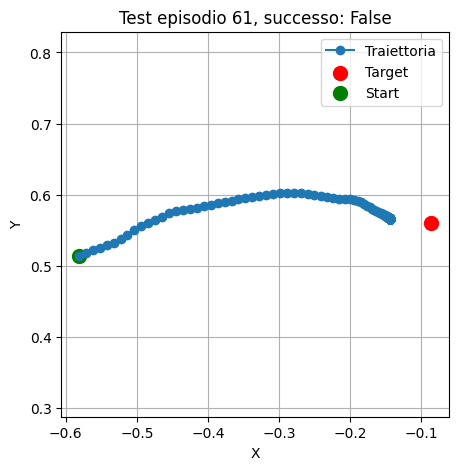

[Episode 62] Steps: 129, Final distance: 0.0188, Success: True


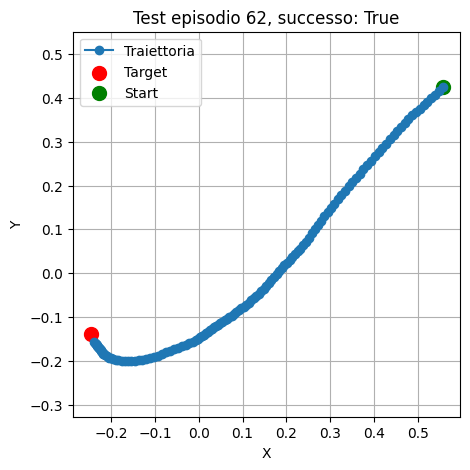

[Episode 63] Steps: 162, Final distance: 0.0192, Success: True


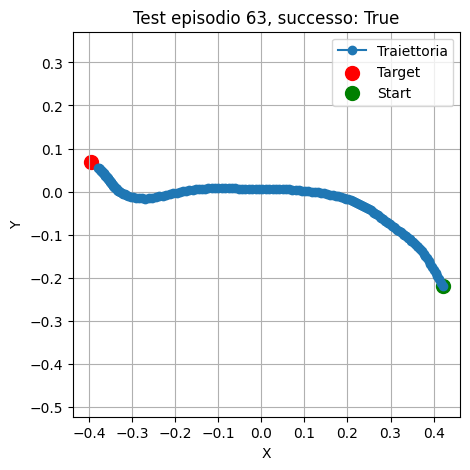

[Episode 64] Steps: 400, Final distance: 0.0304, Success: False


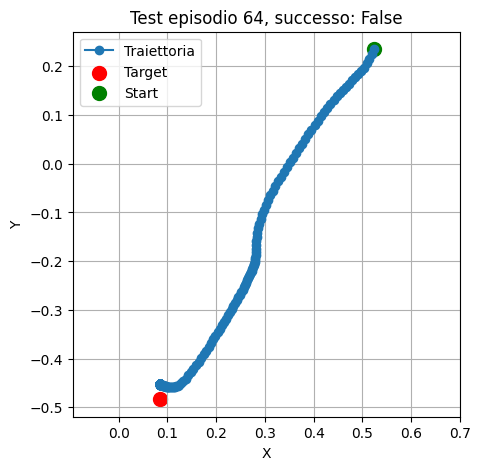

[Episode 65] Steps: 70, Final distance: 0.0151, Success: True


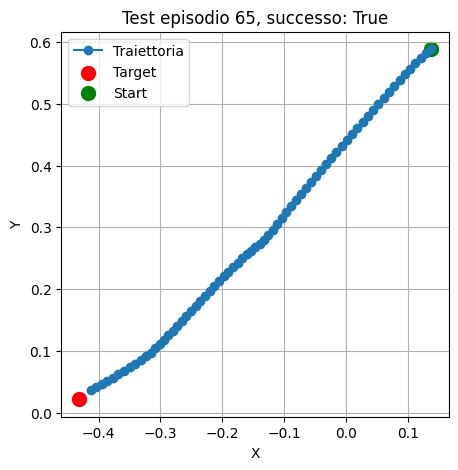

[Episode 66] Steps: 34, Final distance: 0.0197, Success: True


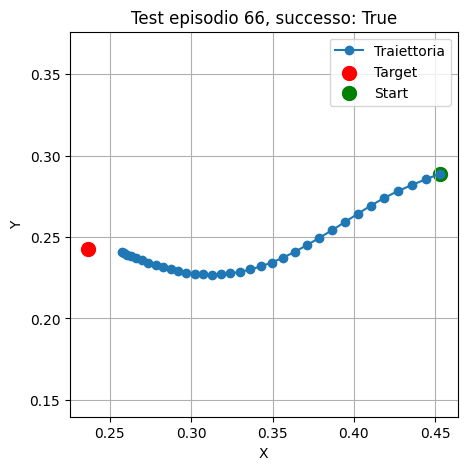

[Episode 67] Steps: 400, Final distance: 0.1139, Success: False


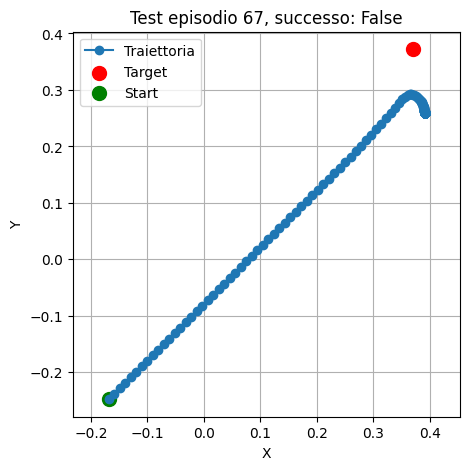

[Episode 68] Steps: 62, Final distance: 0.0194, Success: True


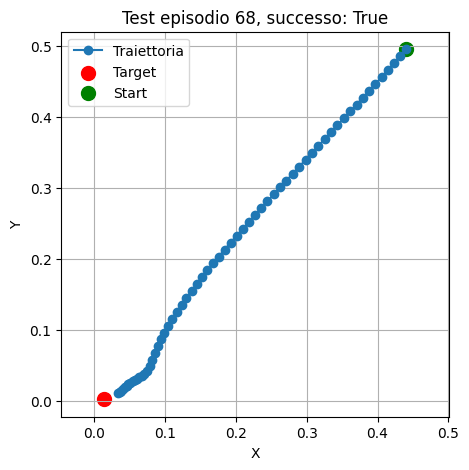

[Episode 69] Steps: 400, Final distance: 0.0634, Success: False


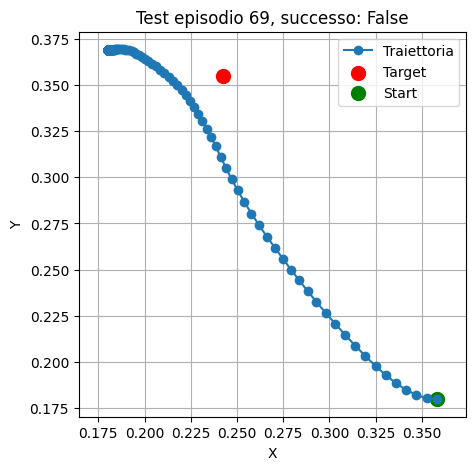

[Episode 70] Steps: 400, Final distance: 0.2538, Success: False


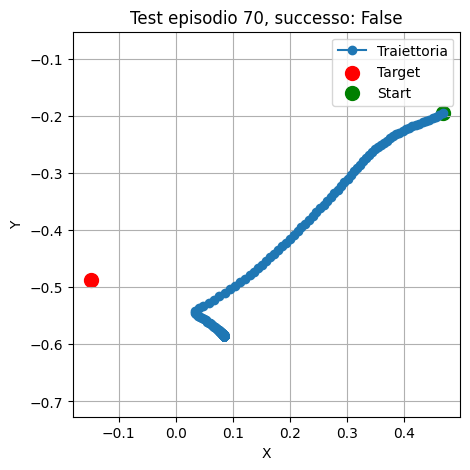

[Episode 71] Steps: 121, Final distance: 0.0197, Success: True


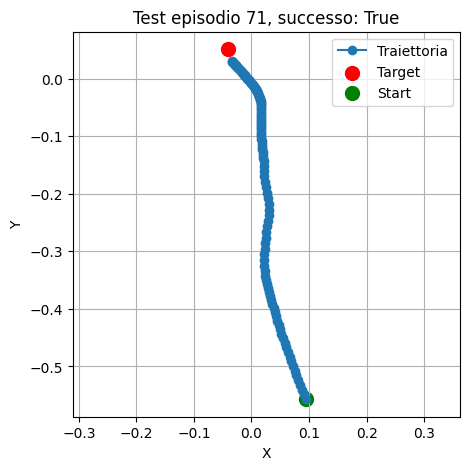

[Episode 72] Steps: 400, Final distance: 0.4879, Success: False


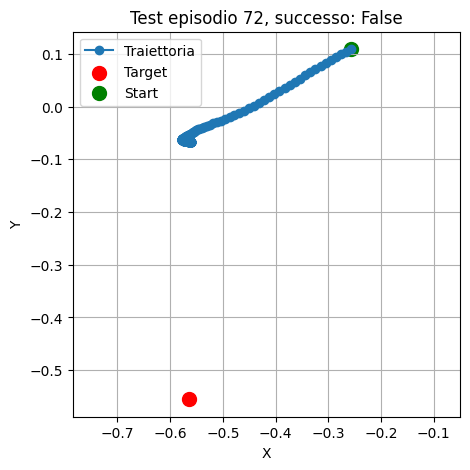

[Episode 73] Steps: 400, Final distance: 0.0331, Success: False


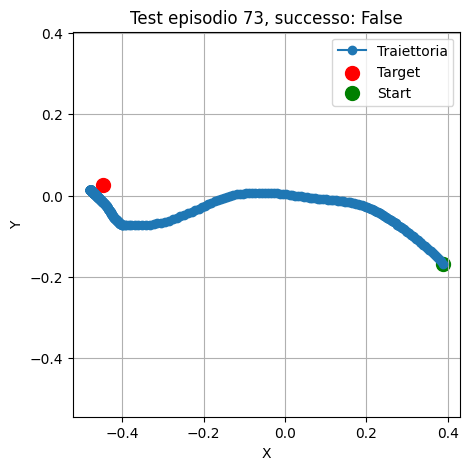

[Episode 74] Steps: 400, Final distance: 0.0448, Success: False


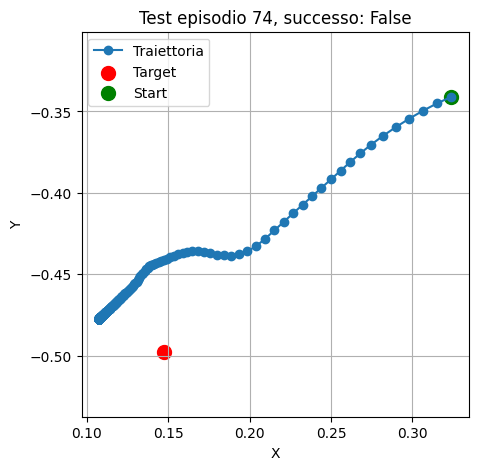

[Episode 75] Steps: 400, Final distance: 0.0220, Success: False


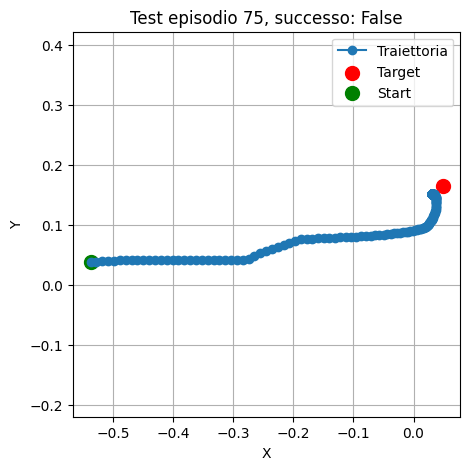

[Episode 76] Steps: 98, Final distance: 0.0188, Success: True


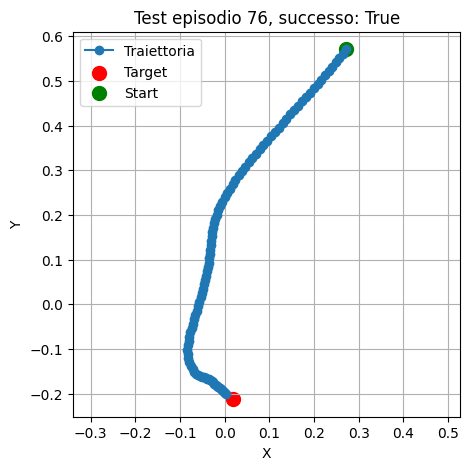

[Episode 77] Steps: 400, Final distance: 0.2255, Success: False


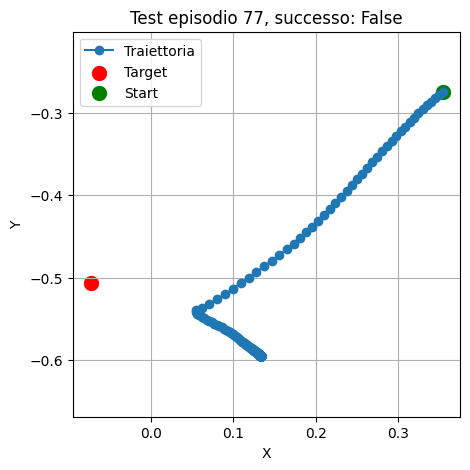

[Episode 78] Steps: 400, Final distance: 0.0592, Success: False


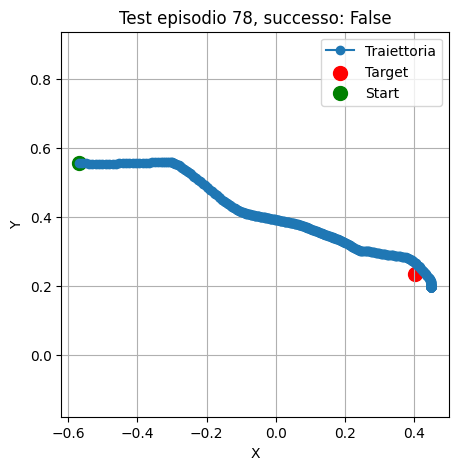

[Episode 79] Steps: 400, Final distance: 0.0318, Success: False


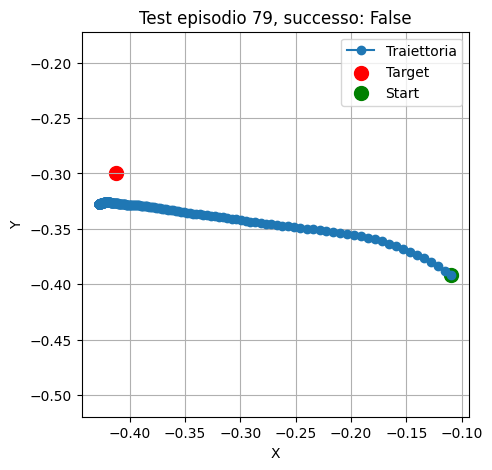

[Episode 80] Steps: 400, Final distance: 0.0390, Success: False


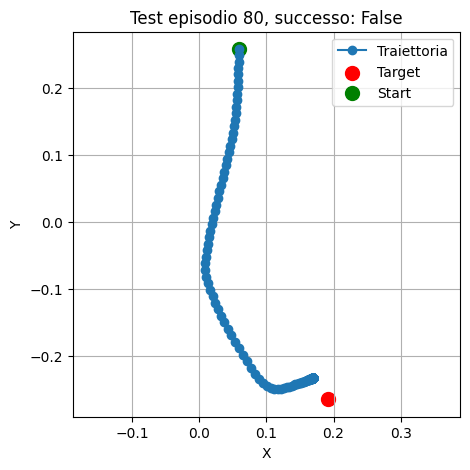

[Episode 81] Steps: 122, Final distance: 0.0196, Success: True


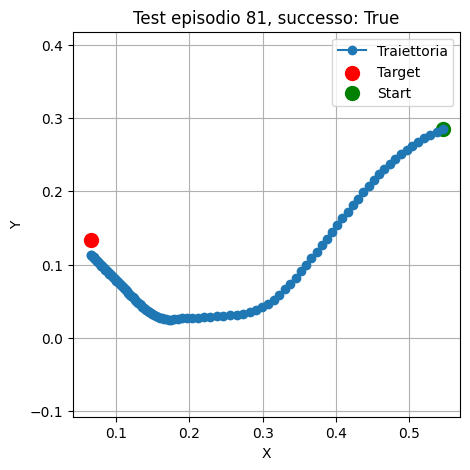

[Episode 82] Steps: 400, Final distance: 0.0515, Success: False


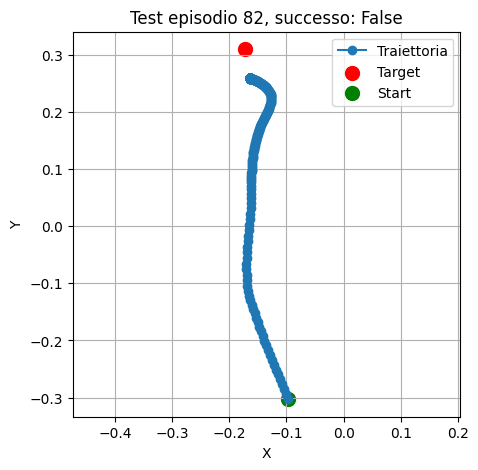

[Episode 83] Steps: 400, Final distance: 0.0605, Success: False


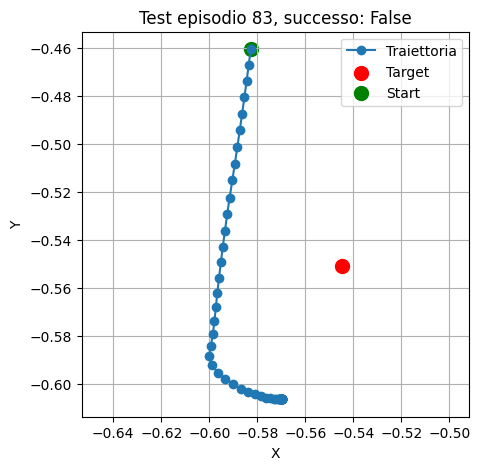

[Episode 84] Steps: 400, Final distance: 0.1028, Success: False


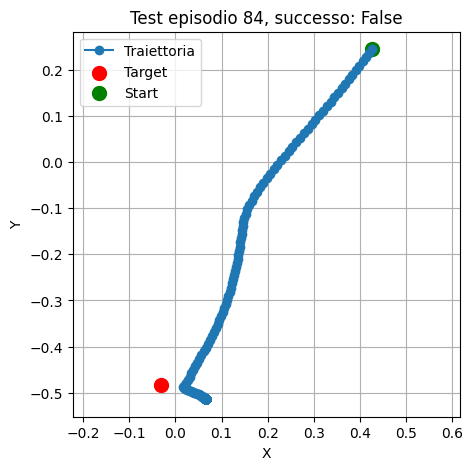

[Episode 85] Steps: 400, Final distance: 0.0937, Success: False


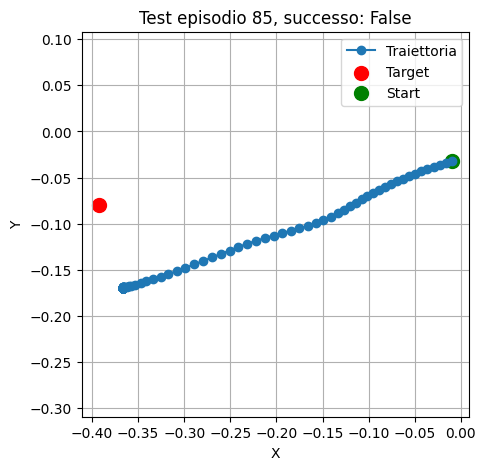

[Episode 86] Steps: 400, Final distance: 0.0572, Success: False


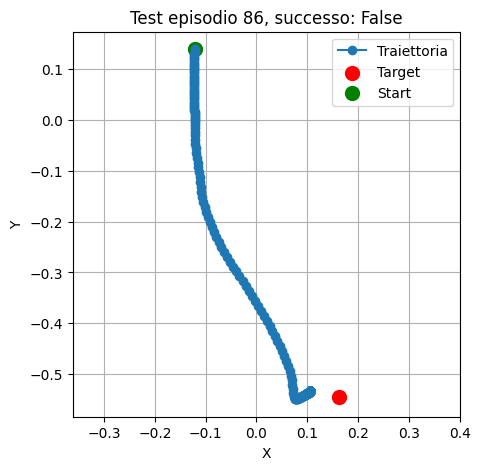

[Episode 87] Steps: 32, Final distance: 0.0193, Success: True


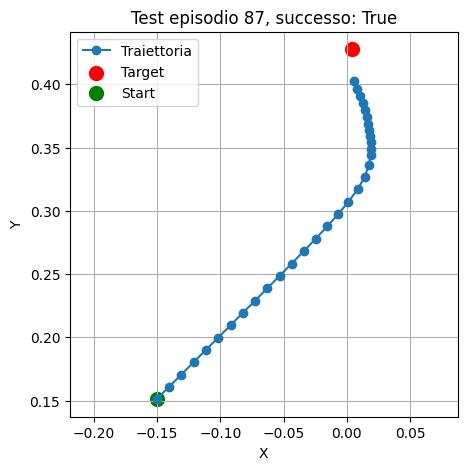

[Episode 88] Steps: 400, Final distance: 0.0645, Success: False


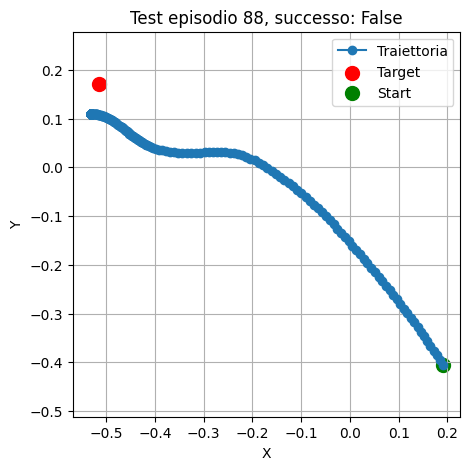

[Episode 89] Steps: 400, Final distance: 0.1233, Success: False


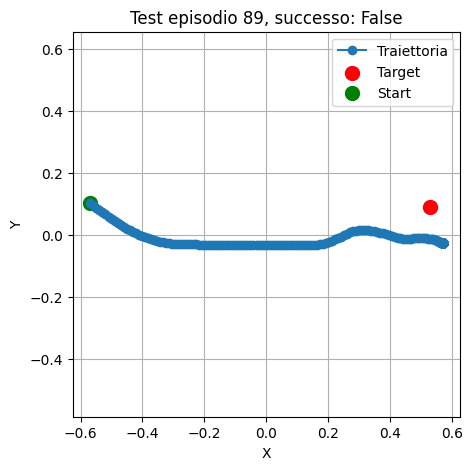

[Episode 90] Steps: 400, Final distance: 0.0337, Success: False


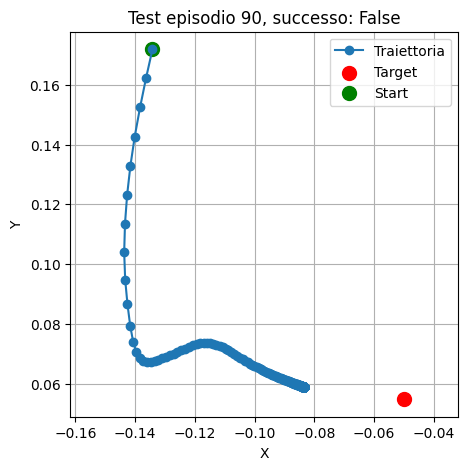

[Episode 91] Steps: 400, Final distance: 0.1643, Success: False


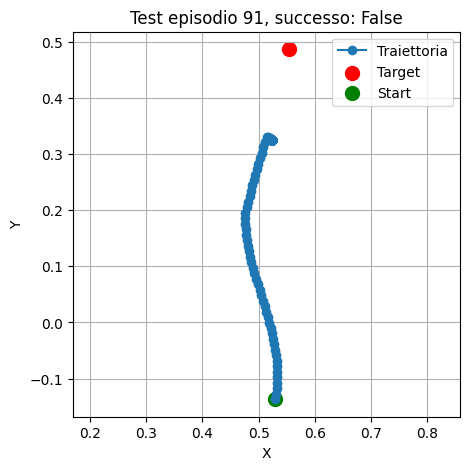

[Episode 92] Steps: 25, Final distance: 0.0174, Success: True


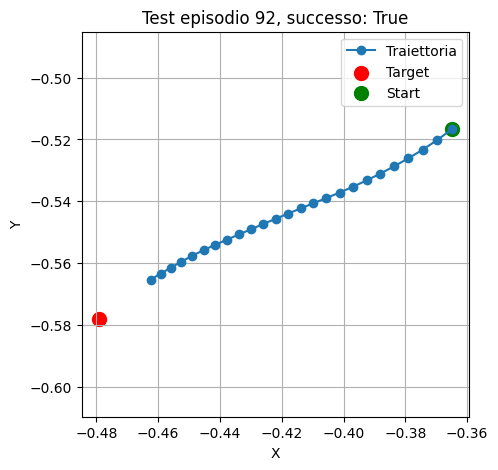

[Episode 93] Steps: 400, Final distance: 0.3108, Success: False


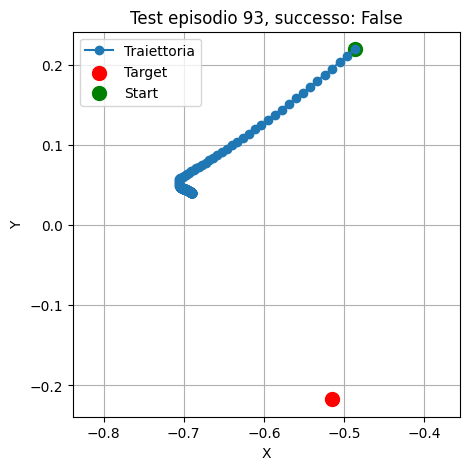

[Episode 94] Steps: 400, Final distance: 0.0423, Success: False


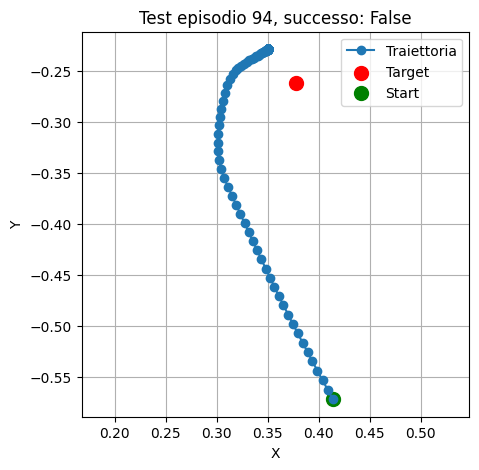

[Episode 95] Steps: 400, Final distance: 0.0706, Success: False


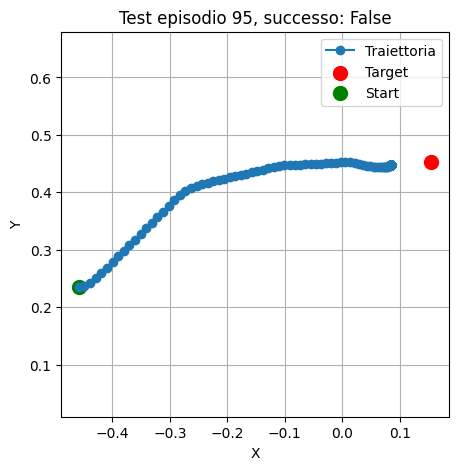

[Episode 96] Steps: 400, Final distance: 0.1753, Success: False


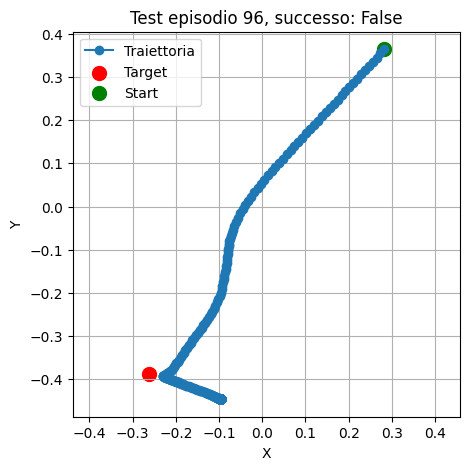

[Episode 97] Steps: 400, Final distance: 0.1017, Success: False


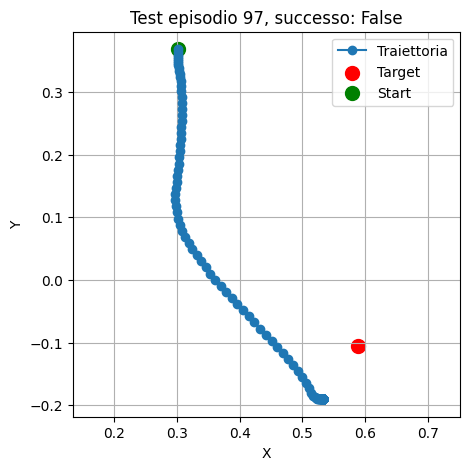

[Episode 98] Steps: 400, Final distance: 0.0282, Success: False


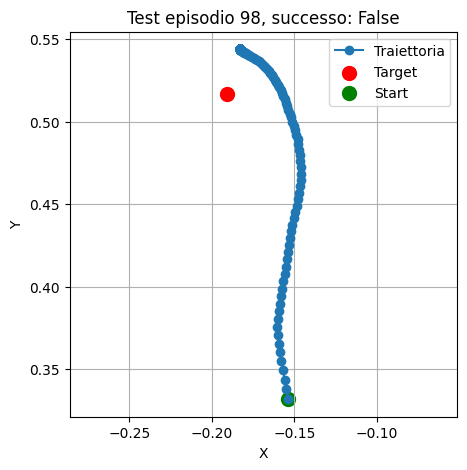

[Episode 99] Steps: 45, Final distance: 0.0186, Success: True


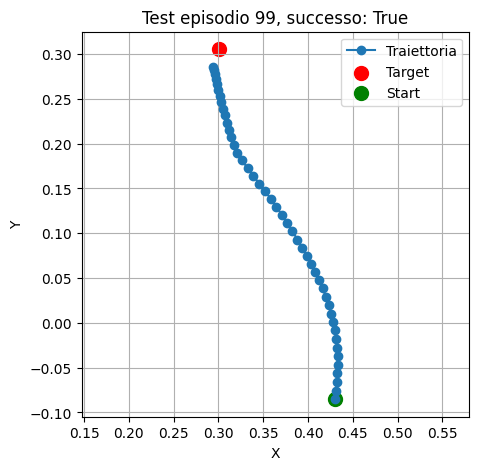


Media distanza finale: 0.1027
Numero successi: 31 / 100


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from environment import TrackingEnv
from ddpg import DDPGAgent, PolicyNet, QNet

def load_agent(checkpoint_path, env=None):
    if env is None:
        env = TrackingEnv()
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    agent = DDPGAgent(state_dim, action_dim)
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    agent.actor.load_state_dict(checkpoint['actor_state_dict'])
    agent.critic.load_state_dict(checkpoint['critic_state_dict'])
    agent.eval()
    return agent

def test_agent_with_random_targets(agent, env=None, num_episodes=100, tolerance=0.02):
    if env is None:
        env = TrackingEnv()

    agent.eval()
    final_distances = []
    success_counter = 0

    for ep in range(num_episodes):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32)
        done = False
        step = 0
        trajectory = []

        while not done:
            trajectory.append(state.detach().numpy())
            with torch.no_grad():
                action = agent.actor(state).detach().numpy()
            next_state, _, done, truncated, _, _ = env.step(action)
            next_state = torch.tensor(next_state, dtype=torch.float32)
            if torch.norm(next_state[:2] - next_state[2:4]) < tolerance or truncated:
                done = True
            state = next_state
            step += 1

        final_dist = np.linalg.norm(state[:2] - state[2:4])
        final_distances.append(final_dist)
        success = final_dist < tolerance
        if success:
            success_counter += 1

        print(f"[Episode {ep}] Steps: {step}, Final distance: {final_dist:.4f}, Success: {success}")

        # Plot e salva la traiettoria
        trajectory = np.array(trajectory)
        plt.figure(figsize=(5, 5))
        plt.plot(trajectory[:, 0], trajectory[:, 1], marker='o', label="Traiettoria")
        plt.scatter(*state[2:4], color='red', label='Target', s=100)
        plt.scatter(trajectory[0, 0], trajectory[0, 1], color='green', label='Start', s=100)
        plt.title(f"Test episodio {ep}, successo: {success}")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.legend()
        plt.grid()
        plt.axis('equal')
        plt.show()


    env.close()
    print(f"\nMedia distanza finale: {np.mean(final_distances):.4f}")
    print(f"Numero successi: {success_counter} / {num_episodes}")

if __name__ == "__main__":
    checkpoint = "runs/ddpg_run_20250412_120431/checkpoint_ep3950.pth"

    agent = load_agent(checkpoint)
    test_agent_with_random_targets(agent)
